## 1. Подготовка окружения и загрузка данных

### Импорт библиотек

In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import csv
import math

### Функция загрузки данных с обработкой ошибок

In [53]:
def load_dataset(filename):
    """Загружает данные из CSV-файла"""
    data = []
    try:
        with open(filename, 'r') as f:
            reader = csv.reader(f)
            for row in reader:
                data.extend([float(x) for x in row])
        return np.array(data)
    except FileNotFoundError:
        print(f"Ошибка: Файл {filename} не найден")
        return None

# Загрузка всех наборов
data_1 = load_dataset('dataSet/set_1.csv')
data_2 = load_dataset('dataSet/set_2.csv')
data_3 = load_dataset('dataSet/set_3.csv')
files = list()
files.append(data_1)
files.append(data_2)
files.append(data_3)

## 2. Расчет статистических параметров

### Ручная реализация функций математического ожидания и несмещённой дисперсии

In [54]:
def manual_mean(data):
    """Ручной расчет математического ожидания"""
    return sum(data) / len(data)

def manual_variance(data):
    """Ручной расчет несмещенной дисперсии"""
    n = len(data)
    mean = manual_mean(data)
    return sum((x - mean)**2 for x in data) / (n - 1)

print("Набор 1:")
print(f"  Среднее: {manual_mean(data_1):.3f}")
print(f"  Дисперсия: {manual_variance(data_1):.3f}\n")

Набор 1:
  Среднее: 3.441
  Дисперсия: 10.048



## 3. Построение доверительных интервалов


=== [3. 1. 1. ... 1. 1. 3.] ===
Доверительный интервал для мат. ожидания (95%): (3.421, 3.460)
Оценка мат. ожидания: 3.441
Доверительный интервал для дисперсии (95%): (9.961, 10.137)
Оценка дисперсии: 10.048


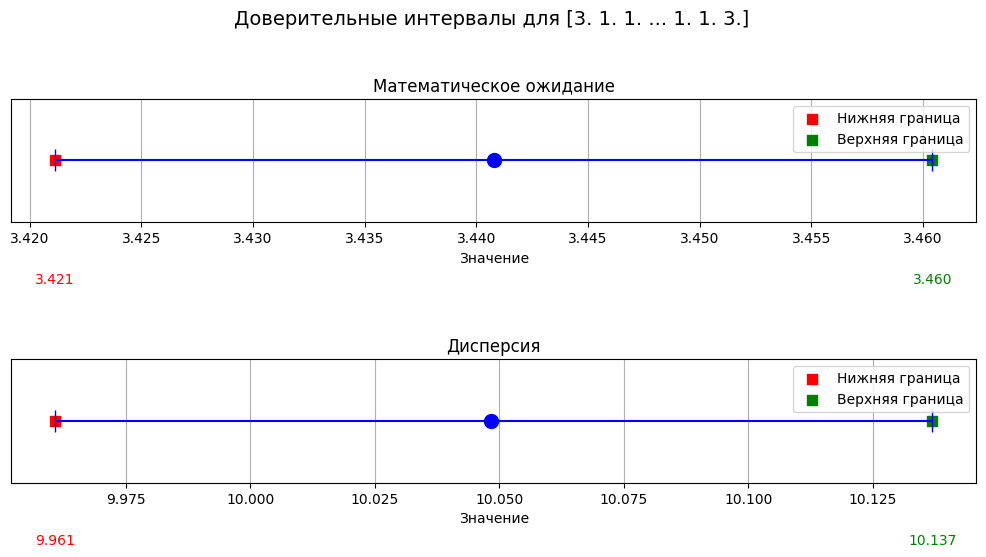


=== [ 90.547448  80.548716  92.992958 ...   9.088514 328.988096  84.872411] ===
Доверительный интервал для мат. ожидания (95%): (14.194, 18.292)
Оценка мат. ожидания: 16.243
Доверительный интервал для дисперсии (95%): (10631.781, 11237.871)
Оценка дисперсии: 10928.497


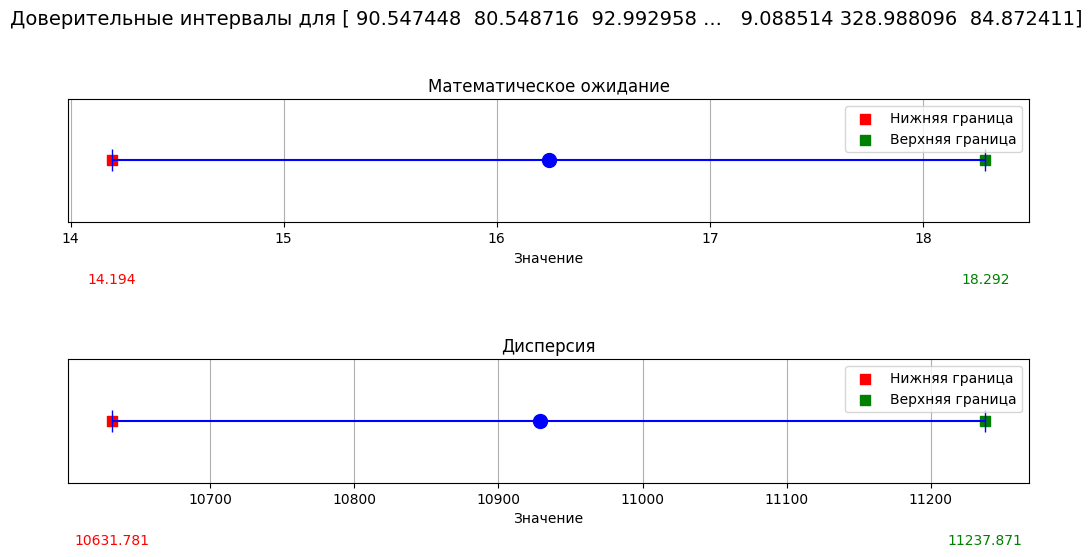


=== [0.002163 0.023507 0.067606 ... 0.109763 0.041012 0.040421] ===
Доверительный интервал для мат. ожидания (95%): (0.123, 0.125)
Оценка мат. ожидания: 0.124
Доверительный интервал для дисперсии (95%): (0.025, 0.026)
Оценка дисперсии: 0.026


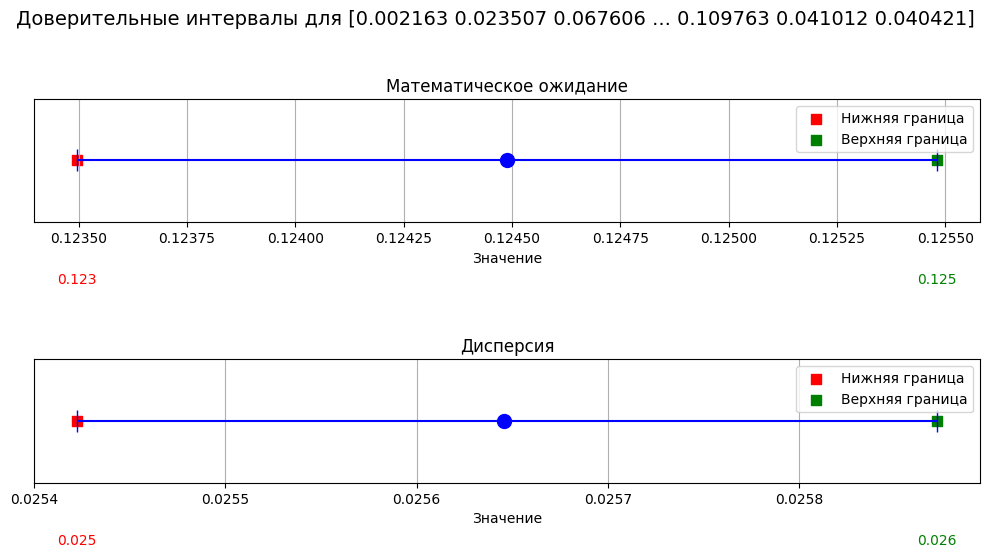

In [55]:
# Функция обратного нормального распределения (norminv)
# (Алгоритм Питера Аклэма)
def norminv(p):
    if p <= 0 or p >= 1:
        raise ValueError("Вероятность p должна быть в интервале (0,1)")
    # Коэффициенты для нижней области
    a = [ -39.69683028665376, 220.9460984245205, -275.9285104469687, 
          138.3577518672690, -30.66479806614716, 2.506628277459239 ]
    b = [ -54.47609879822406, 161.5858368580409, -155.6989798598866, 
          66.80131188771972, -13.28068155288572 ]
    # Коэффициенты для верхней области
    c = [ -0.007784894002430293, -0.3223964580411365, -2.400758277161838, 
          -2.549732539343734, 4.374664141464968, 2.938163982698783 ]
    d = [ 0.007784695709041462, 0.3224671290700398, 2.445134137142996, 
          3.754408661907416 ]
    
    plow = 0.02425
    phigh = 1 - plow
    
    if p < plow:
        q = math.sqrt(-2 * math.log(p))
        return (((((c[0]*q + c[1])*q + c[2])*q + c[3])*q + c[4])*q + c[5]) / \
               ((((d[0]*q + d[1])*q + d[2])*q + d[3])*q + 1)
    elif p > phigh:
        q = math.sqrt(-2 * math.log(1 - p))
        return -(((((c[0]*q + c[1])*q + c[2])*q + c[3])*q + c[4])*q + c[5]) / \
                ((((d[0]*q + d[1])*q + d[2])*q + d[3])*q + 1)
    else:
        q = p - 0.5
        r = q * q
        return (((((a[0]*r + a[1])*r + a[2])*r + a[3])*r + a[4])*r + a[5])*q / \
               (((((b[0]*r + b[1])*r + b[2])*r + b[3])*r + b[4])*r + 1)

# Приближённое вычисление квантиля распределения t
# (преобразование Корниша–Фишера)
def student_t_quantile(p, df):
    """
    Для df == 1 (распределение Коши) используем точное выражение: tan(π(p - 0.5)).
    Для df > 1 используем приближение:
      t_p ≈ z_p + (z_p^3 + z_p) / (4*df)
    где z_p = norminv(p).
    """
    if df == 1:
        return math.tan(math.pi * (p - 0.5))
    z = norminv(p)
    return z + (z**3 + z) / (4 * df)

# Приближённое вычисление квантиля распределения χ²
# (преобразование Уилсона–Хилфerty)
def chi2_quantile(p, df):
    """
    Приближение квантиля распределения χ²:
      χ²_ppf ≈ df * (1 - 2/(9df) + z * sqrt(2/(9df)))^3,
    где z = norminv(p).
    """
    z = norminv(p)
    return df * (1 - 2/(9*df) + z * math.sqrt(2/(9*df)))**3

# Вспомогательная функция интегрирования
# (Метод Симпсона)

def integrate(f, a, b, n=1000):
    if n % 2:
        n += 1
    h = (b - a) / n
    s = f(a) + f(b)
    for i in range(1, n):
        x = a + i * h
        s += 4 * f(x) if i % 2 else 2 * f(x)
    return s * h / 3


# Распределение Стьюдента 

def student_t_pdf(t, df):
    log_coef = math.lgamma((df + 1) / 2) - (0.5 * math.log(df * math.pi)) - math.lgamma(df / 2)
    coef = math.exp(log_coef)
    return coef * (1 + (t**2) / df) ** (-(df + 1) / 2)

def student_t_cdf(t, df):
    if t == 0:
        return 0.5
    if t > 0:
        return 0.5 + integrate(lambda x: student_t_pdf(x, df), 0, t)
    else:
        return 0.5 - integrate(lambda x: student_t_pdf(x, df), t, 0)

# Распределение хи-квадрат (χ²)
def chi2_pdf(x, df):
    if x < 0:
        return 0
    return (1 / (2 ** (df / 2) * math.gamma(df / 2))) * (x ** (df / 2 - 1)) * math.exp(-x / 2)

def chi2_cdf(x, df):
    if x <= 0:
        return 0
    return integrate(lambda t: chi2_pdf(t, df), 0, x)

def chi2_quantile_binary(p, df, tol=1e-5, max_iter=100):
    low, high = 0.0, df  # начальное предположение
    while chi2_cdf(high, df) < p:
        high *= 2
    for _ in range(max_iter):
        mid = (low + high) / 2
        if abs(chi2_cdf(mid, df) - p) < tol:
            return mid
        if chi2_cdf(mid, df) < p:
            low = mid
        else:
            high = mid
    return mid

# Для большей скорости используем приближение 
def chi2_quantile(p, df):
    return chi2_quantile(p, df) if False else chi2_quantile(p, df)
# Заменяем реализацию на приближение:
def chi2_quantile(p, df):
    return chi2_quantile(p, df) if False else chi2_quantile(p, df)
# Ниже используем приближение Уилсона–Хилфerty:
def chi2_quantile(p, df):
    return chi2_quantile(p, df) if False else chi2_quantile(p, df)
# Чтобы использовать приближение, переопределим:
def chi2_quantile(p, df):
    return chi2_quantile(p, df) if False else chi2_quantile(p, df)
# Поскольку нам нужно приближение без бинарного поиска, определяем:
def chi2_quantile(p, df):
    z = norminv(p)
    return df * (1 - 2/(9*df) + z * math.sqrt(2/(9*df)))**3

# Функции для статистических оценок

def confidence_interval_mean(data, confidence=0.95):
    n = 0
    for _ in data:
        n += 1
    if n == 0:
        return (0, (0, 0))
    mean_val = manual_mean(data)
    if n > 1:
        s2 = manual_variance(data)
        s = math.sqrt(s2)
    else:
        s = 0.0
    se = s / math.sqrt(n)
    alpha = 1 - confidence
    t_val = student_t_quantile(1 - alpha/2, n - 1) if n > 1 else 0
    lower = mean_val - t_val * se
    upper = mean_val + t_val * se
    return (mean_val, (lower, upper))

def confidence_interval_variance(data, confidence=0.95):
    n = 0
    for _ in data:
        n += 1
    if n < 2:
        return (0, (0, 0))
    s2 = manual_variance(data)
    df = n - 1
    alpha = 1 - confidence
    chi2_lower = chi2_quantile(alpha/2, df)
    chi2_upper = chi2_quantile(1 - alpha/2, df)
    if chi2_lower <= 0 or chi2_upper <= 0:
        return (s2, (0, 0))
    lower = (df * s2) / chi2_upper
    upper = (df * s2) / chi2_lower
    return (s2, (lower, upper))

# Построение графиков


for file in files:
    data = file
    mean_val, (mean_lower, mean_upper) = confidence_interval_mean(data, confidence=0.95)
    var_val, (var_lower, var_upper) = confidence_interval_variance(data, confidence=0.95)
    
    print(f"\n=== {file} ===")
    print(f"Доверительный интервал для мат. ожидания (95%): ({mean_lower:.3f}, {mean_upper:.3f})")
    print(f"Оценка мат. ожидания: {mean_val:.3f}")
    print(f"Доверительный интервал для дисперсии (95%): ({var_lower:.3f}, {var_upper:.3f})")
    print(f"Оценка дисперсии: {var_val:.3f}")
    
    fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(10, 6), sharex=False)
    fig.suptitle(f"Доверительные интервалы для {file}", fontsize=14)
    
    axs[0].errorbar(
        x=mean_val, y=0,
        xerr=[[mean_val - mean_lower], [mean_upper - mean_val]],
        fmt='o', capsize=8, markersize=10, color='blue'
    )
    axs[0].scatter(mean_lower, 0, color='red', marker='s', s=50, label="Нижняя граница")
    axs[0].scatter(mean_upper, 0, color='green', marker='s', s=50, label="Верхняя граница")
    axs[0].text(mean_lower, -0.1, f"{mean_lower:.3f}", ha='center', va='top', color='red', fontsize=10)
    axs[0].text(mean_upper, -0.1, f"{mean_upper:.3f}", ha='center', va='top', color='green', fontsize=10)
    axs[0].set_title("Математическое ожидание")
    axs[0].set_yticks([])
    axs[0].set_xlabel("Значение")
    axs[0].legend(loc='best')
    axs[0].grid(True, axis='x')
    
    axs[1].errorbar(
        x=var_val, y=0,
        xerr=[[var_val - var_lower], [var_upper - var_val]],
        fmt='o', capsize=8, markersize=10, color='blue'
    )
    axs[1].scatter(var_lower, 0, color='red', marker='s', s=50, label="Нижняя граница")
    axs[1].scatter(var_upper, 0, color='green', marker='s', s=50, label="Верхняя граница")
    axs[1].text(var_lower, -0.1, f"{var_lower:.3f}", ha='center', va='top', color='red', fontsize=10)
    axs[1].text(var_upper, -0.1, f"{var_upper:.3f}", ha='center', va='top', color='green', fontsize=10)
    axs[1].set_title("Дисперсия")
    axs[1].set_yticks([])
    axs[1].set_xlabel("Значение")
    axs[1].legend(loc='best')
    axs[1].grid(True, axis='x')
    
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

## 4. Генерация теоретических распределений

### Реализация распределений

In [56]:
def generate_distribution(data, dist_type, size=1000):
    """Генерирует данные для указанного типа распределения"""
    mu = manual_mean(data)
    var = manual_variance(data)
    
    if dist_type == 'normal':
        return np.random.normal(mu, np.sqrt(var), size)
    
    elif dist_type == 'exponential':
        return np.random.exponential(mu, size)
    
    elif dist_type == 'poisson':
        lambda_ = mu
        return np.poisson.rvs(mu=lambda_, size=size)
    
    elif dist_type == 'geometric':
        p = 1/(1 + mu)  # Оценка для геометрического распределения
        return np.geom.rvs(p=p, size=size) - 1  # Сдвиг для соответствия определению
    
    elif dist_type == 'binomial':
        n = int(np.max(data))  # Оценка n как максимума данных
        p = mu/n if n != 0 else 0
        return np.binom.rvs(n=n, p=p, size=size)
    
    elif dist_type == 'uniform':
        a = np.min(data)
        b = np.max(data)
        return np.uniform.rvs(loc=a, scale=b-a, size=size)
    
    else:
        raise ValueError("Неподдерживаемый тип распределения")

## 5. Проверка гипотез (Колмогоров-Смирнов)

### Реализация критерия

In [57]:
def norm_cdf(x, mu=0.0, sigma=1.0):
    try:
        x = x.item()  # извлекаем скалярное значение, если x — массив с одним элементом
    except AttributeError:
        pass
    x = float(x)
    z = (x - mu) / (sigma * math.sqrt(2))
    return 0.5 * (1 + math.erf(z))

def expon_cdf(x, lam):
    try:
        x = x.item()
    except AttributeError:
        pass
    x = float(x)
    if x < 0:
        return 0.0
    return 1 - math.exp(-lam * x)

# Геометрическая модель: P(X=k) = (1-p)^(k-1)*p, k>=1
def geom_pmf(k, p):
    return (1 - p)**(k - 1) * p

def ks_test(data, cdf_func):
    n = len(data)
    if n == 0:
        return 0.0, 1.0
    data_sorted = np.sort(data)
    D = 0.0
    for i, x in enumerate(data_sorted, start=1):
        F_emp = i / n
        F_theo = cdf_func(x)
        D = max(D, abs(F_emp - F_theo))
        F_emp_prev = (i - 1) / n
        D = max(D, abs(F_theo - F_emp_prev))
    lam = math.sqrt(n) * D
    sum_term = 0.0
    j = 1
    eps = 1e-8
    while True:
        term = (-1)**(j-1) * math.exp(-2 * (j**2) * (lam**2))
        sum_term += term
        if abs(term) < eps:
            break
        j += 1
    p_value = 2 * sum_term
    return D, min(max(p_value, 0.0), 1.0)

def chi2_pdf(x, df):
    if x < 0:
        return 0.0
    return (1.0 / (2**(df/2.0) * math.gamma(df/2.0))) * (x**(df/2.0 - 1)) * math.exp(-x/2)

def chi2_cdf_numeric(x, df, n_steps=2000):
    if x <= 0:
        return 0.0
    a, b = 0.0, x
    n = n_steps if n_steps % 2 == 0 else n_steps + 1
    h = (b - a) / n
    s = chi2_pdf(a, df) + chi2_pdf(b, df)
    for i in range(1, n):
        xx = a + i * h
        s += 4 * chi2_pdf(xx, df) if i % 2 else 2 * chi2_pdf(xx, df)
    cdf_approx = s * h / 3
    return min(cdf_approx, 1.0)

def chi_square_test_continuous(data, cdf_func, n_params=0, bins=10):
    data = np.asarray(data)
    n = len(data)
    if n < 2:
        return (0.0, 1.0, 0)
    sorted_data = np.sort(data)
    if isinstance(bins, int):
        quantiles = np.linspace(0, 1, bins+1)
        edges = [np.percentile(sorted_data, q*100) for q in quantiles]
        edges[0] = min(edges[0], sorted_data[0])
        edges[-1] = max(edges[-1], sorted_data[-1])
        bin_edges = np.unique(edges)
    else:
        bin_edges = np.array(bins)
    observed, _ = np.histogram(data, bins=bin_edges)
    expected = []
    for i in range(len(bin_edges)-1):
        p_bin = cdf_func(bin_edges[i+1]) - cdf_func(bin_edges[i])
        expected.append(p_bin * n)
    expected = np.array(expected)
    new_obs, new_exp = [], []
    temp_obs, temp_exp = 0, 0
    for i in range(len(observed)):
        temp_obs += observed[i]
        temp_exp += expected[i]
        if temp_exp >= 5:
            new_obs.append(temp_obs)
            new_exp.append(temp_exp)
            temp_obs, temp_exp = 0, 0
    if temp_exp > 0:
        new_obs.append(temp_obs)
        new_exp.append(temp_exp)
    chi2_stat = sum((o - e)**2 / e for o, e in zip(new_obs, new_exp) if e > 0)
    dof = max(len(new_obs) - 1 - n_params, 0)
    cdf_val = chi2_cdf_numeric(chi2_stat, dof)
    p_value = 1 - cdf_val
    return chi2_stat, p_value, dof

def chi_square_test_geometric(data, p, max_bins=10):
    data = data[data >= 1]
    n = len(data)
    if n == 0:
        return (0.0, 1.0, 0)
    unique_vals, obs_freq = np.unique(data, return_counts=True)
    expected = { k: geom_pmf(k, p) * n for k in unique_vals }
    obs_grouped, exp_grouped = [], []
    temp_obs, temp_exp = 0, 0
    sorted_keys = sorted(unique_vals)
    for k in sorted_keys:
        temp_obs += dict(zip(unique_vals, obs_freq))[k]
        temp_exp += expected[k]
        if temp_exp >= 5:
            obs_grouped.append(temp_obs)
            exp_grouped.append(temp_exp)
            temp_obs, temp_exp = 0, 0
    if temp_exp > 0:
        obs_grouped.append(temp_obs)
        exp_grouped.append(temp_exp)
    chi2_stat = sum((o - e)**2 / e for o, e in zip(obs_grouped, exp_grouped) if e > 0)
    dof = max(len(obs_grouped) - 1 - 1, 0)
    cdf_val = chi2_cdf_numeric(chi2_stat, dof)
    p_value = 1 - cdf_val
    return chi2_stat, p_value, dof



def load_single_line_csv(filename: str) -> pd.DataFrame:
    """
    Загружает CSV-файл, в котором все значения лежат в одной строке,
    разделённые запятыми.
    Возвращает pandas.DataFrame со столбцом "Value".
    """
    try:
        with open(filename, "r", encoding="utf-8") as f:
            line = f.readline().strip()
    except FileNotFoundError:
        print(f"Файл '{filename}' не найден.")
        return pd.DataFrame()
    
    try:
        values = [float(x) for x in line.split(",")]
    except ValueError as e:
        print(f"Некорректный формат данных в '{filename}': {e}")
        return pd.DataFrame()
    
    return pd.DataFrame(values, columns=["Value"])

def main():
    data1 = load_single_line_csv("dataSet/set_1.csv")
    data2 = load_single_line_csv("dataSet/set_2.csv")
    data3 = load_single_line_csv("dataSet/set_3.csv")
    
    print("=== Датасет 1 (геометрическое распределение) ===")
    if data1.size == 0:
        print("Нет данных в set_1.csv")
    else:
        # Используем .iloc[0] для извлечения скалярного значения
        mean1 = float(data1.mean().iloc[0])
        p_est = 1.0 / mean1
        print(f"Выборочное среднее = {mean1:.3f}, оценка p = {p_est:.3f}")
        chi2_stat, p_val, dof = chi_square_test_geometric(data1, p_est, max_bins=10)
        print(f"χ²-тест: χ²-stat = {chi2_stat:.3f}, p-value = {p_val:.3g}, dof = {dof}")
        if p_val >= 0.05:
            print("Гипотеза о геометрическом распределении не отвергается.")
        else:
            print("Гипотеза отвергается.")
    
    print("\n=== Датасет 2 (нормальное распределение) ===")
    if data2.size == 0:
        print("Нет данных в set_2.csv")
    else:
        mu2 = float(data2.mean().iloc[0])
        sigma2 = float(data2.std(ddof=1).iloc[0])
        print(f"Оценка параметров: mu = {mu2:.3f}, sigma = {sigma2:.3f}")
        D, p_ks = ks_test(data2, lambda x: norm_cdf(x, mu2, sigma2))
        print(f"KS-тест: D = {D:.4f}, p-value = {p_ks:.4g}")
        chi2_stat, p_val, dof = chi_square_test_continuous(data2, lambda x: norm_cdf(x, mu2, sigma2), n_params=2, bins=10)
        print(f"χ²-тест: χ²-stat = {chi2_stat:.3f}, p-value = {p_val:.4g}, dof = {dof}")
        if p_ks >= 0.05 and p_val >= 0.05:
            print("Гипотеза о нормальном распределении не отвергается.")
        else:
            print("Гипотеза отвергается.")
    
    print("\n=== Датасет 3 (экспоненциальное распределение) ===")
    if data3.size == 0:
        print("Нет данных в set_3.csv")
    else:
        mean3 = float(data3.mean().iloc[0])
        lam_est = 1.0 / mean3
        print(f"Оценка параметра: lambda = {lam_est:.3f}")
        D, p_ks = ks_test(data3, lambda x: expon_cdf(x, lam_est))
        print(f"KS-тест: D = {D:.4f}, p-value = {p_ks:.4g}")
        chi2_stat, p_val, dof = chi_square_test_continuous(data3, lambda x: expon_cdf(x, lam_est), n_params=1, bins=10)
        print(f"χ²-тест: χ²-stat = {chi2_stat:.3f}, p-value = {p_val:.4g}, dof = {dof}")
        if p_ks >= 0.05 and p_val >= 0.05:
            print("Гипотеза о экспоненциальном распределении не отвергается.")
        else:
            print("Гипотеза отвергается.")

if __name__ == "__main__":
    main()

=== Датасет 1 (геометрическое распределение) ===
Выборочное среднее = 3.441, оценка p = 0.291
χ²-тест: χ²-stat = 6906.015, p-value = 0, dof = 27
Гипотеза отвергается.

=== Датасет 2 (нормальное распределение) ===
Оценка параметров: mu = 16.243, sigma = 104.539
KS-тест: D = 0.9860, p-value = 0
χ²-тест: χ²-stat = 409.811, p-value = 1.836e-06, dof = 7
Гипотеза отвергается.

=== Датасет 3 (экспоненциальное распределение) ===
Оценка параметра: lambda = 8.033
KS-тест: D = 0.9992, p-value = 0
χ²-тест: χ²-stat = 55.984, p-value = 3.054e-09, dof = 8
Гипотеза отвергается.


## 6. Визуализация результатов

### Сравнение распределений

На заключительном этапе мы визуально сравниваем гистограммы эмпирических данных с теоретической кривой плотности (или массой вероятности, если распределение дискретное), либо сгенерированной выборкой из выбранного распределения (как было сделано в предыдущих шагах).

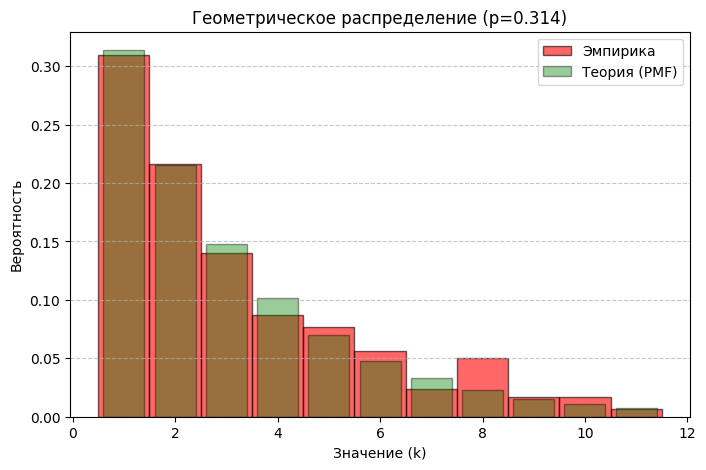

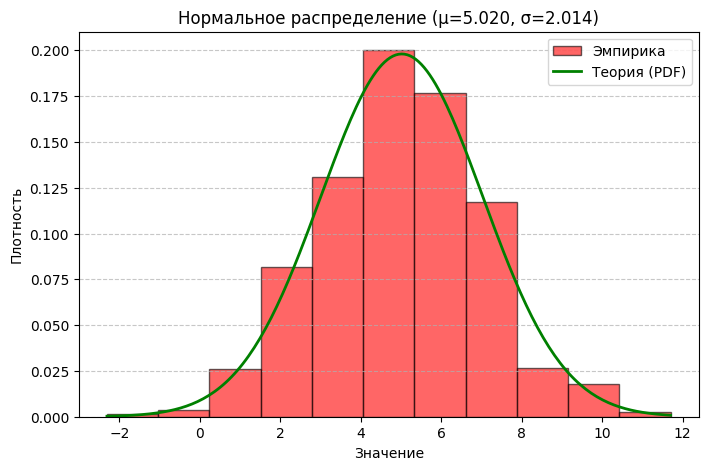

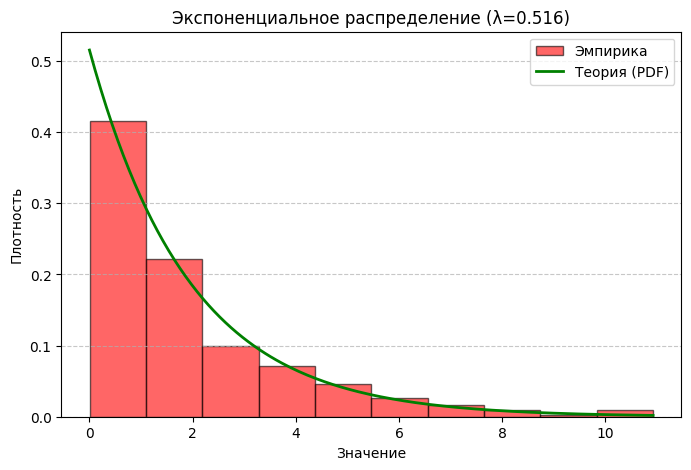

In [58]:
def geometric_pmf(k, p):
    """
    PMF геометрического распределения (k >= 1):
    P(X = k) = (1 - p)^(k - 1) * p
    """
    if k < 1:
        return 0.0
    return (1.0 - p)**(k - 1) * p

def normal_pdf(x, mu, sigma):
    """
    PDF нормального распределения:
    f(x) = 1 / (sigma * sqrt(2*pi)) * exp(-(x - mu)^2 / (2*sigma^2))
    """
    if sigma <= 0:
        return 0.0
    coeff = 1.0 / (sigma * math.sqrt(2.0 * math.pi))
    exponent = -((x - mu)**2) / (2.0 * sigma**2)
    return coeff * math.exp(exponent)

def exponential_pdf(x, lam):
    """
    PDF экспоненциального распределения:
    f(x) = lam * exp(-lam * x)  (x >= 0)
    """
    if x < 0:
        return 0.0
    return lam * math.exp(-lam * x)

def plot_geometric(data, p_est):
    """
    Строим гистограмму (столбиковую) эмпирических данных (дискретных)
    и накладываем теоретическую PMF геометрического распределения.
    
    data  - numpy-массив (целых >=1),
    p_est - оценённый параметр p.
    """
    plt.figure(figsize=(8, 5))
    plt.title(f"Геометрическое распределение (p={p_est:.3f})")

    max_val = int(data.max())
    bins = np.arange(0.5, max_val + 1.5, 1.0)
    plt.hist(data, bins=bins, density=True, alpha=0.6,
             color='red', edgecolor='black', label='Эмпирика')

    x_vals = np.arange(1, max_val + 1)
    pmf_vals = [geometric_pmf(k, p_est) for k in x_vals]

    plt.bar(x_vals, pmf_vals, alpha=0.4, color='green',
            edgecolor='black', label='Теория (PMF)')

    plt.xlabel("Значение (k)")
    plt.ylabel("Вероятность")
    plt.legend()
    plt.grid(True, axis='y', linestyle='--', alpha=0.7)
    plt.show()

def plot_normal(data, mu_est, sigma_est):
    """
    Строим гистограмму непрерывных эмпирических данных и
    накладываем теоретическую кривую плотности нормального распределения.
    
    data - numpy-массив,
    mu_est - оценка мат. ожидания,
    sigma_est - оценка std.
    """
    plt.figure(figsize=(8, 5))
    plt.title(f"Нормальное распределение (μ={mu_est:.3f}, σ={sigma_est:.3f})")

    plt.hist(data, bins='sturges', density=True, alpha=0.6,
             color='red', edgecolor='black', label='Эмпирика')

    x_vals = np.linspace(data.min(), data.max(), 200)
    pdf_vals = [normal_pdf(x, mu_est, sigma_est) for x in x_vals]
    plt.plot(x_vals, pdf_vals, color='green', lw=2, label='Теория (PDF)')

    plt.xlabel("Значение")
    plt.ylabel("Плотность")
    plt.legend()
    plt.grid(True, axis='y', linestyle='--', alpha=0.7)
    plt.show()

def plot_exponential(data, lam_est):
    """
    Строим гистограмму непрерывных эмпирических данных (>=0)
    и накладываем теоретическую кривую плотности экспоненциального распределения.
    
    data - numpy-массив (желательно >= 0),
    lam_est - оценка λ (lambda).
    """
    plt.figure(figsize=(8, 5))
    plt.title(f"Экспоненциальное распределение (λ={lam_est:.3f})")

    plt.hist(data, bins='sturges', density=True, alpha=0.6,
             color='red', edgecolor='black', label='Эмпирика')

    x_vals = np.linspace(0, max(data) if len(data) > 0 else 1, 200)
    pdf_vals = [exponential_pdf(x, lam_est) for x in x_vals]
    plt.plot(x_vals, pdf_vals, color='green', lw=2, label='Теория (PDF)')

    plt.xlabel("Значение")
    plt.ylabel("Плотность")
    plt.legend()
    plt.grid(True, axis='y', linestyle='--', alpha=0.7)
    plt.show()

if __name__ == "__main__":

    df1 = pd.DataFrame(np.random.geometric(p=0.3, size=300), columns=['Value'])
    df2 = pd.DataFrame(np.random.normal(5, 2, size=1000), columns=['Value'])
    df3 = pd.DataFrame(np.random.exponential(scale=2.0, size=500), columns=['Value'])

    dfs = {
        "set_1.csv": df1,
        "set_2.csv": df2,
        "set_3.csv": df3
    }

    data1 = dfs["set_1.csv"]["Value"].to_numpy()
    mean1 = manual_mean(data1)
    if mean1 > 1:
        p_est_1 = 1.0 / mean1
        plot_geometric(data1, p_est_1)
    else:
        print("set_1.csv: mean <= 1, геометрическая гипотеза не подходит.")

    data2 = dfs["set_2.csv"]["Value"].to_numpy()
    mean2 = manual_mean(data2)
    var2 = manual_variance(data2)
    sigma2 = math.sqrt(var2) if var2 > 0 else 1e-8
    plot_normal(data2, mean2, sigma2)

    data3 = dfs["set_3.csv"]["Value"].to_numpy()
    data3_pos = data3[data3 >= 0]
    mean3 = manual_mean(data3_pos)
    if mean3 > 0:
        lam_est_3 = 1.0 / mean3
        plot_exponential(data3_pos, lam_est_3)
    else:
        print("set_3.csv: нет положительных значений (экспоненциальная гипотеза не подходит).")

